In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
#min_df = 5 #Minimum number for document frequency in the corpus
#rm_top = 5 #Remove top n frequent words



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        
        if article != []:
            preprocessed_data.append(article)

        #print(article)
    return preprocessed_data
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

In [3]:
#Carefull!!! Takes about 90 minutes! If you already have a model saved, then use the prep_arr() class!!!!


# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection = preprocess(prep_collection)

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries = preprocess(prep_queries)

#print(prep_queries)
#print(prep_collection)

In [2]:
#Savable data array class


class prep_arr(object):
    def __init__(self, data_arr=[]):
        self.data_arr = data_arr

    def save(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

    def load(self, path):
        with open(path, 'rb') as inp:
            prep_arr_load = pickle.load(inp)
        self.data_arr = prep_arr_load.data_arr
    

In [5]:
#Crfeate querry collection ensemble
querries_collection_dataset = []
for x in prep_queries:
    querries_collection_dataset.append(x)
for x in prep_collection:
    querries_collection_dataset.append(x)

In [6]:
#Save cleaned arrays

arr_q = prep_arr(prep_queries)
arr_q.save("./cleaned_data/prep_queries.txt")
arr_c = prep_arr(prep_collection)
arr_c.save("./cleaned_data/prep_collection.txt")

arr_qc = prep_arr(querries_collection_dataset)
arr_qc.save("./cleaned_data/querries_collection_dataset.txt")

In [7]:
print(len(prep_queries))
print(len(prep_collection))
print(len(querries_collection_dataset))

50
7849
7899


In [3]:
#Load the saved arrays

load_q = prep_arr()
load_q.load("./cleaned_data/prep_queries.txt")
prep_queries = load_q.data_arr

load_c = prep_arr()
load_c.load("./cleaned_data/prep_collection.txt")
prep_collection = load_c.data_arr

load_qc = prep_arr()
load_qc.load("./cleaned_data/querries_collection_dataset.txt")
querries_collection_dataset = load_qc.data_arr

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

def detokenize(dataset):
    detokenized_dataset = []
    for t in dataset:
        text = ""
        for w in t:
            text = text + w + " "
        detokenized_dataset.append(text.rstrip())

    #print(detokenized_dataset)
    return detokenized_dataset

def tf_idf_cleaner(dataset, tf_idf_scores, min_score):
    clean_dataset = []
    dropped_documents = []
    i = 0
    for text in dataset:
        t = []
        for word in text:
            if word in tf_idf_scores.columns:
                score = tf_idf_scores.iloc[i][word]
                if (score >= min_score):
                    t.append(word)
        if t != []:
            clean_dataset.append(t)
        else:
            print('empty text on line ', i)
            dropped_documents.append(i)
        i = i + 1
    #print(clean_dataset)
    return clean_dataset, dropped_documents




def tf_idf(dataset, min_score=0):
    dataset_detokenized = detokenize(dataset)
    #vec=TfidfVectorizer(stop_words='english')
    ##Create Vectors
    #matrix=vec.fit_transform(dataset)
    #print("Feature Names n",vec.get_feature_names_out())
    #print(matrix[0].toarray())
    #print("Sparse Matrix n",matrix.shape,"n",matrix.toarray())


    countvectorizer = CountVectorizer(analyzer= 'word')
    tfidfvectorizer = TfidfVectorizer(analyzer='word')
    count_wm = countvectorizer.fit_transform(dataset_detokenized)
    tfidf_wm = tfidfvectorizer.fit_transform(dataset_detokenized)
    count_tokens = countvectorizer.get_feature_names()
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

    #print("Count Vectorizer\n")
    #print(df_countvect)
    #print("\nTF-IDF Vectorizer\n")
    #print(df_tfidfvect)
    #df_tfidfvect.to_csv('tfidf.csv')

    if(min_score > 0):
        dataset, dropped_documents = tf_idf_cleaner(dataset,df_tfidfvect,min_score)

    return dataset, df_countvect, df_tfidfvect, dropped_documents

    #terms = countvectorizer.fit_transform(dataset_detokenized)
    #term_vectors  = countvectorizer.transform(dataset_detokenized)
    #print("Sparse Matrix form of test data : \n")
    #print(term_vectors.todense())

    #tfidf = TfidfTransformer(norm='l2')
    #term_vectors.todense()
    #tfidf.fit(term_vectors)
    #tf_idf_matrix = tfidf.transform(term_vectors)
    #print("\nVector of idf \n")
    #print(tfidf.idf_)
    #print("\nFinal tf-idf vectorizer matrix form :\n")
    #print(tf_idf_matrix.todense())


querries_collection_dataset, df_countvect, df_tfidfvect, dropped_documents = tf_idf(querries_collection_dataset, min_score=0.2)
prep_collection = querries_collection_dataset[50:]
prep_querries = querries_collection_dataset[:50]

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


empty text on line  2857


In [5]:
# Create Dictionary
id2word = corpora.Dictionary(querries_collection_dataset)
# Create Corpus
texts = prep_collection
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(105, 1), (235, 1), (236, 1), (237, 1), (238, 1)]


In [6]:
from pprint import pprint
# number of topics
num_topics = 8
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"information" + 0.010*"program" + 0.009*"amplifier" + '
  '0.007*"analysis" + 0.006*"method" + 0.006*"control" + 0.006*"service" + '
  '0.006*"radio" + 0.006*"transistor" + 0.005*"satellite"'),
 (1,
  '0.008*"science" + 0.008*"energy" + 0.008*"circuit" + 0.007*"information" + '
  '0.007*"amplifier" + 0.006*"library" + 0.006*"datum" + 0.006*"journal" + '
  '0.005*"education" + 0.005*"wave"'),
 (2,
  '0.024*"network" + 0.022*"system" + 0.011*"book" + 0.011*"language" + '
  '0.009*"wave" + 0.008*"filter" + 0.008*"information" + 0.007*"retrieval" + '
  '0.006*"programming" + 0.006*"frequency"'),
 (3,
  '0.020*"information" + 0.019*"datum" + 0.009*"school" + 0.009*"time" + '
  '0.007*"amplifier" + 0.006*"layer" + 0.006*"height" + 0.006*"noise" + '
  '0.006*"circuit" + 0.005*"region"'),
 (4,
  '0.028*"library" + 0.016*"field" + 0.012*"information" + 0.010*"catalogue" + '
  '0.009*"public" + 0.007*"university" + 0.007*"book" + 0.007*"magnetic" + '
  '0.007*"pm" + 0.005*"theory"'

In [7]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.015217  0.042051       1        1  14.084429
6      0.085876 -0.005816       2        1  13.609473
3      0.043280  0.034797       3        1  13.187900
4     -0.065609  0.045571       4        1  13.039780
2      0.003848 -0.143935       5        1  12.719665
0      0.057598  0.050624       6        1  11.551971
7     -0.118187  0.015927       7        1  11.171057
1     -0.022023 -0.039218       8        1  10.635725, topic_info=            Term        Freq       Total Category  logprob  loglift
69       network  402.000000  402.000000  Default  30.0000  30.0000
15        system  830.000000  830.000000  Default  29.0000  29.0000
111      library  613.000000  613.000000  Default  28.0000  28.0000
115        field  408.000000  408.000000  Default  27.0000  27.0000
741     research  217.000000  217.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
180     electron   43.785429  416.804984   Topic8  -5.3990  -0.0124
69       network   39.553455  402.548967   Topic8  -5.5006  -0.0792
259       public   33.523082  252.871483   Topic8  -5.6660   0.2203
130  measurement   30.698698  154.441021   Topic8  -5.7540   0.6254
571        pulse   30.137332  267.200653   Topic8  -5.7725   0.0587

[648 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2293      8  0.886493         abn
303       1  0.409024  absorption
303       2  0.033390  absorption
303       3  0.108517  absorption
303       4  0.041737  absorption
...     ...       ...         ...
8804      5  0.820159   yorkshire
7719      8  0.886437    yugoslav
4596      5  0.875139         zag
3302      3  0.947856         zbb
4597      5  0.874850         zig

[2056 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 5, 3, 1, 8, 2])

In [8]:
import math
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=prep_collection)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic_querries = df_dominant_topic[df_dominant_topic['Document_No'] < 50]
#print(df_dominant_topic_querries)

df_dominant_topic_querries = df_dominant_topic_querries[df_dominant_topic_querries['Text'].notna()]
df_dominant_topic_collection = df_dominant_topic[df_dominant_topic['Document_No'] >= 50]
df_dominant_topic_collection = df_dominant_topic_collection[df_dominant_topic_collection['Text'].notna()]

df_dominant_topic = df_dominant_topic[df_dominant_topic['Text'].notna()]

print(df_dominant_topic)
#print(df_dominant_topic_querries['Text'])

      Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0             4.0              0.8539   
1               1             7.0              0.6848   
2               2             4.0              0.9270   
3               3             0.0              0.7807   
4               4             5.0              0.9270   
...           ...             ...                 ...   
7843         7843             4.0              0.9374   
7844         7844             0.0              0.9374   
7845         7845             3.0              0.9270   
7846         7846             6.0              0.7630   
7847         7847             6.0              0.6336   

                                               Keywords  \
0     library, field, information, catalogue, public...   
1     research, information, circuit, field, voltage...   
2     library, field, information, catalogue, public...   
3     information, program, amplifier, analysis, met...   
4     system, servic

In [13]:
print(len(df_dominant_topic_querries))
print(len(df_dominant_topic_collection))


50
7798


In [9]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9841,"information, program, amplifier, analysis, method, control, service, radio, transistor, satellite","[programming, style, functional, style, program, programming, language, style, programming, prog..."
1,1.0,0.9735,"science, energy, circuit, information, amplifier, library, datum, journal, education, wave","[structural, recognition, carotid, pulse, wave, waveform, parse, waveform, parse, structural, re..."
2,2.0,0.9801,"network, system, book, language, wave, filter, information, retrieval, programming, frequency","[model, database, organization, datum, retrieval, system, datum, retrieval, system, model, datum..."
3,3.0,0.9775,"information, datum, school, time, amplifier, layer, height, noise, circuit, region","[schedule, independent, task, mean, finish, time, minimize, mean, finish, time, mean, time, mini..."
4,4.0,0.9775,"library, field, information, catalogue, public, university, book, magnetic, pm, theory","[problem, design, layout, problem, dps, design, task, design, layout, task, design, task, plan, ..."
5,5.0,0.9781,"system, service, electron, frequency, method, information, pulse, effect, layer, library","[performance, keytoaddress, transformation, method, file, performance, keytoaddress, transformat..."
6,6.0,0.9886,"system, computer, function, design, information, electron, index, amplifier, density, filter","[datum, communication, control, procedure, datum, communication, datum, communication, control, ..."
7,7.0,0.9742,"research, information, circuit, field, voltage, catalogue, solar, report, frequency, conductivity","[list, structure, list, structure, regularity, poin, ter, poin, ter, list, poin, ter, list, poin..."


In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=prep_collection)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.8539,"library, field, information, catalogue, public, university, book, magnetic, pm, theory","[computer, university, part, reeve, pm]"
1,1,7.0,0.6847,"research, information, circuit, field, voltage, catalogue, solar, report, frequency, conductivity","[synthetic, image, image, surface, model, image, image, model, surface, image, image, image, ter..."
2,2,4.0,0.9270,"library, field, information, catalogue, public, university, book, magnetic, pm, theory","[training, assistant, mauritius, mauritius, course, training, assistant, experiment, course, exp..."
3,3,0.0,0.7807,"information, program, amplifier, analysis, method, control, service, radio, transistor, satellite","[electrostatic, centre, conductor]"
4,4,5.0,0.9270,"system, service, electron, frequency, method, information, pulse, effect, layer, library","[note, note, meteor, midday, meteor, tendency, peak, occur, reversed, peak, occur]"
...,...,...,...,...,...
95,95,1.0,0.9416,"science, energy, circuit, information, amplifier, library, datum, journal, education, wave","[midf, malaysian, industrial, finance, midf, subsidiary, company, midf, malaysian, industrial, f..."
96,96,2.0,0.7386,"network, system, book, language, wave, filter, information, retrieval, programming, frequency","[network, cooperation, cooperation, service, service, act, network, network, network, service, s..."
97,97,4.0,0.5084,"library, field, information, catalogue, public, university, book, magnetic, pm, theory","[public, public, library, ideal, pursue, real, nihilism, practicality, public, library, race, li..."
98,98,2.0,0.9124,"network, system, book, language, wave, filter, information, retrieval, programming, frequency","[stabilization, direct, supply, functional, diagram, stabilization, supply, load, load]"


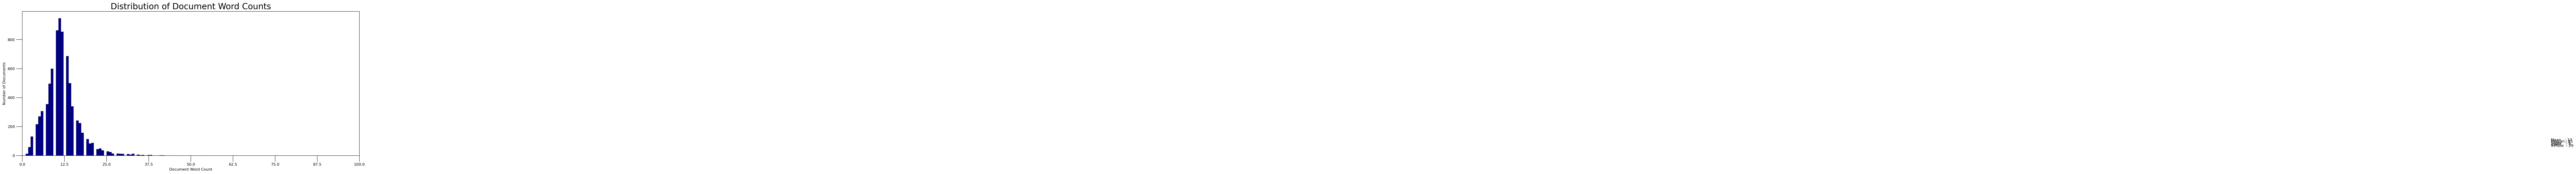

In [12]:
#print([len(d) for d in df_dominant_topic.Text])
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

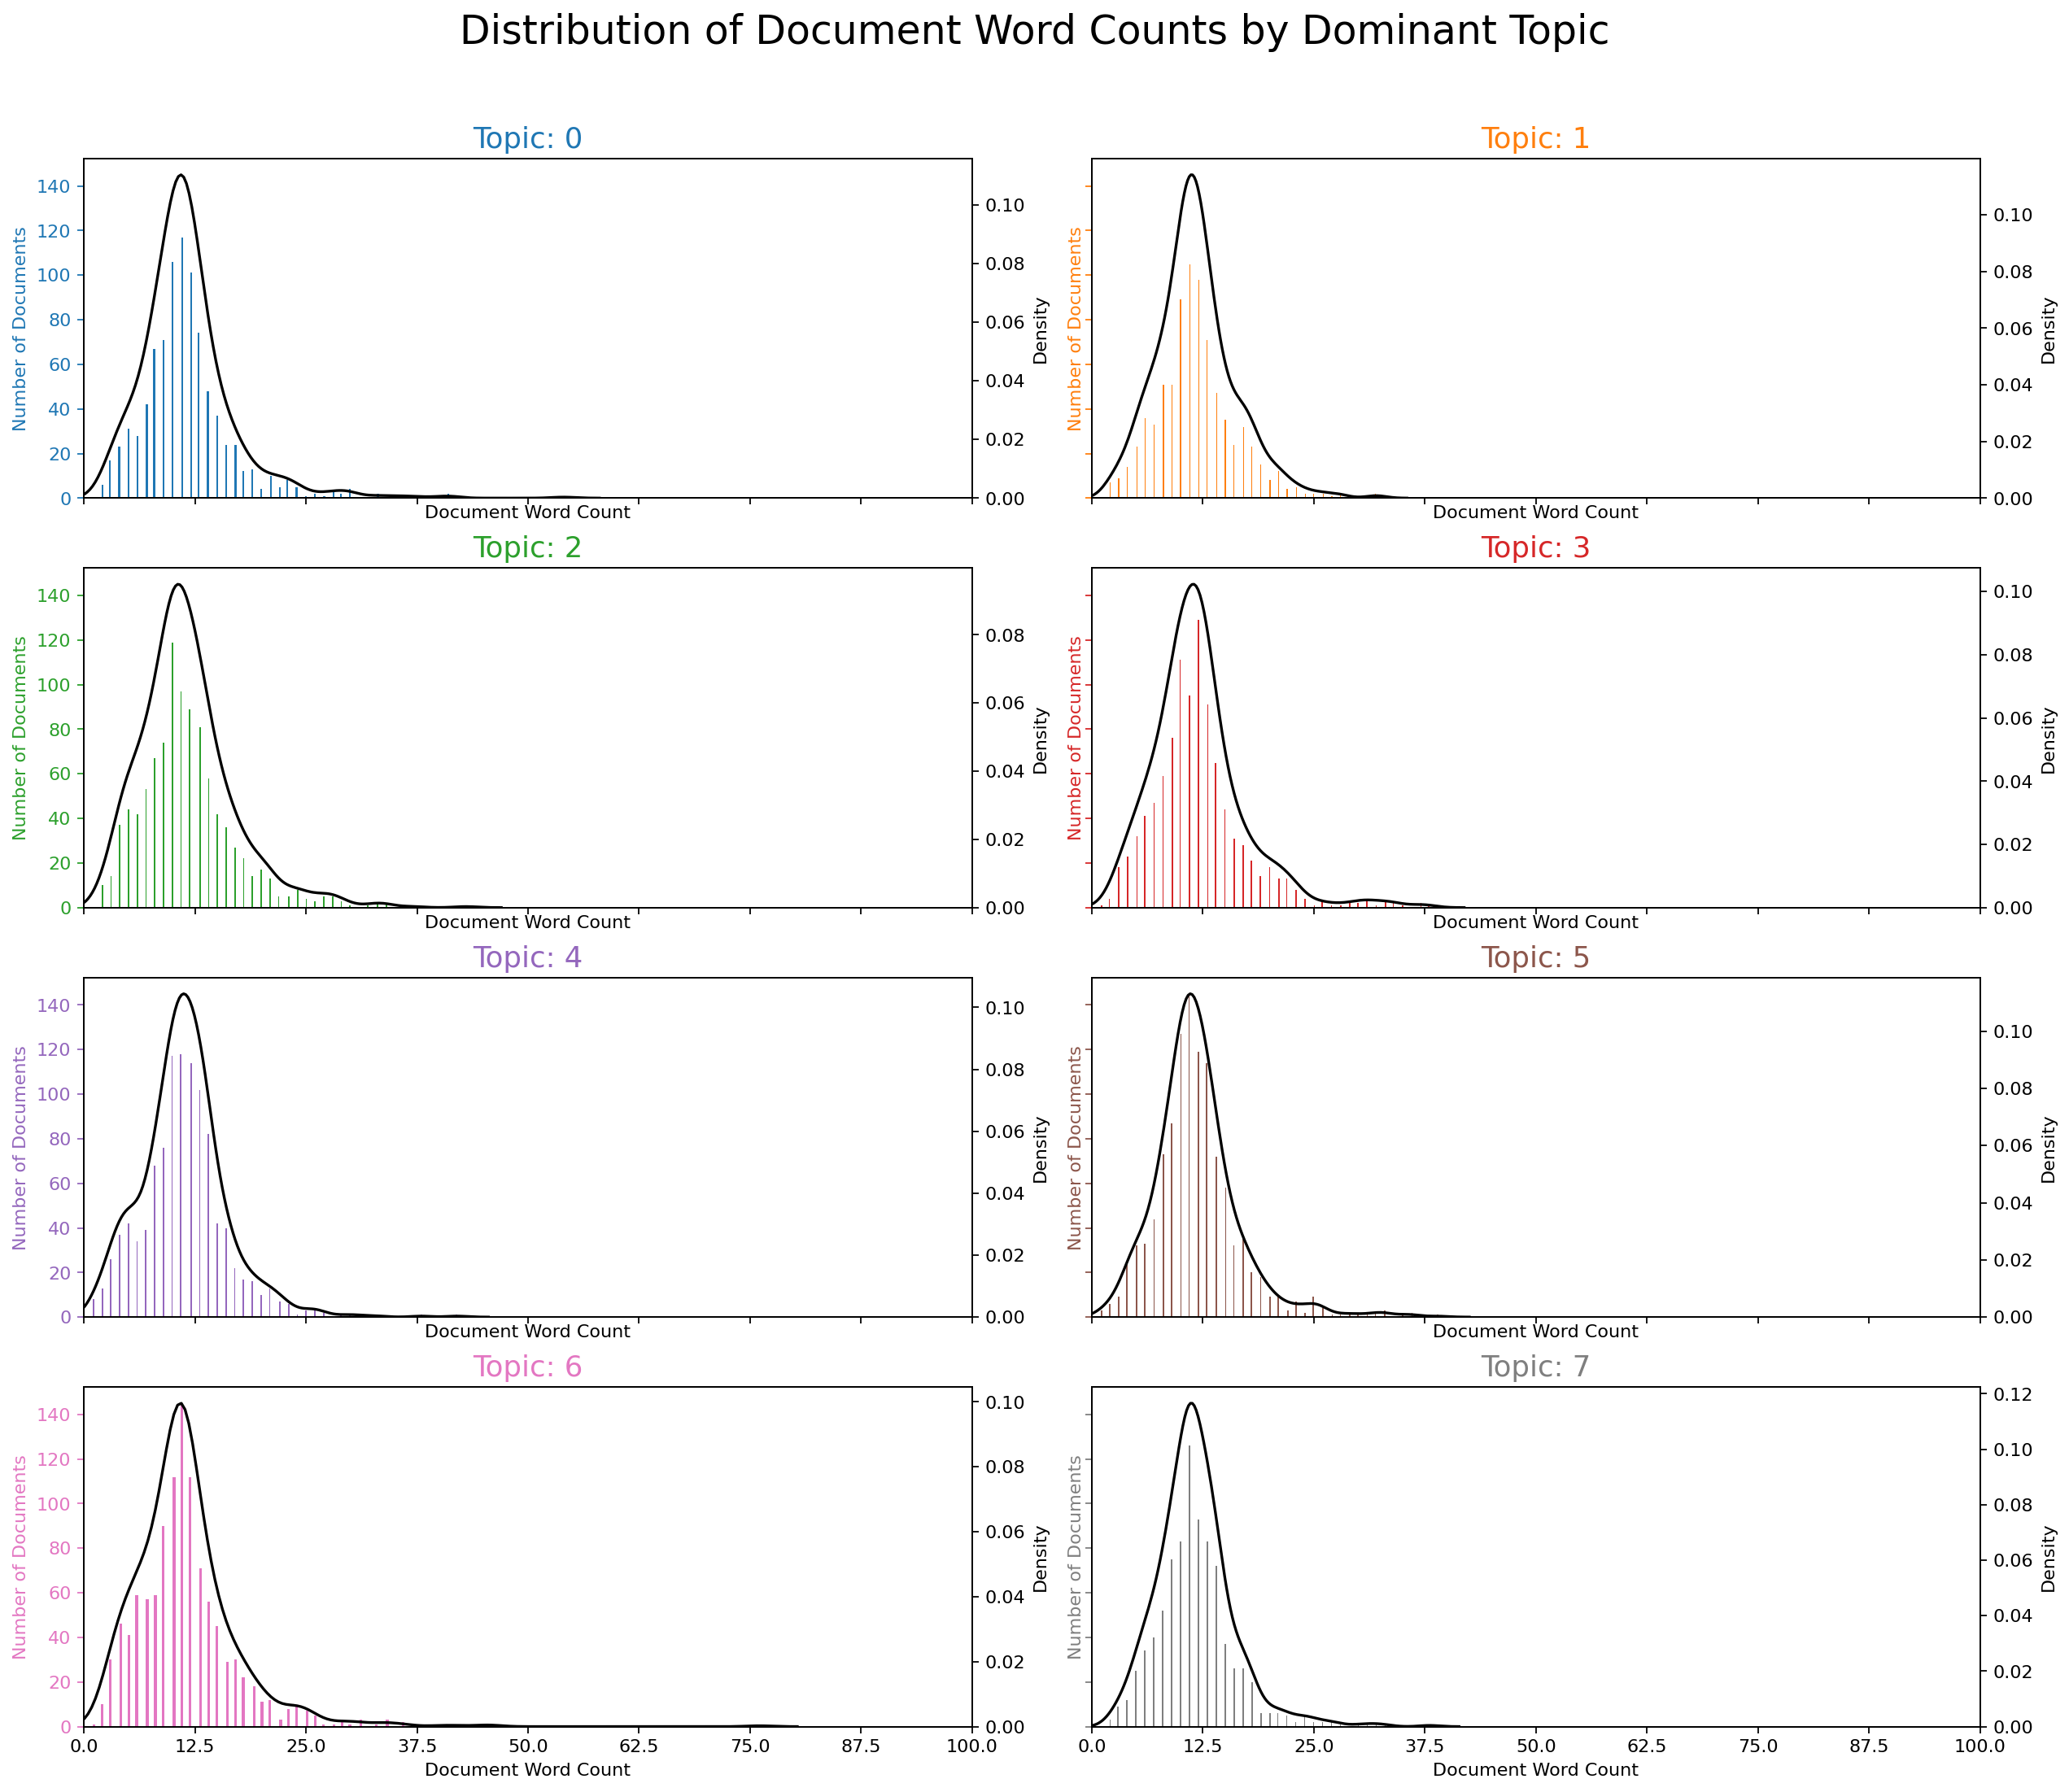

In [13]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(round(num_topics/2),2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 250, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

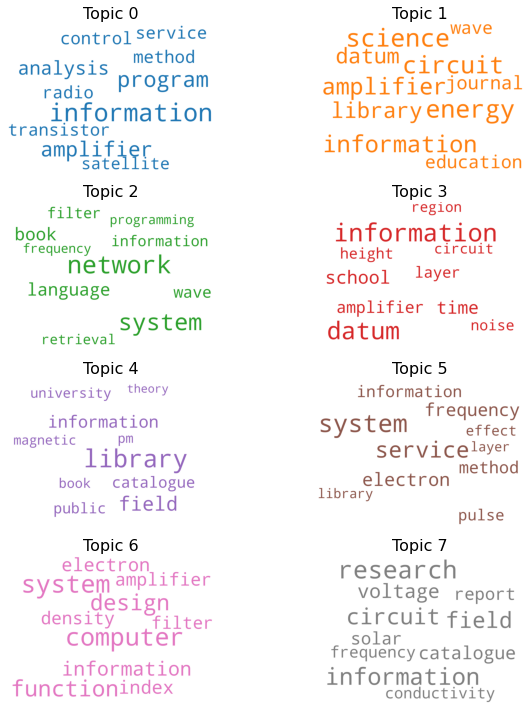

In [14]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\TEMP/ipykernel_10364/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_10364/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_10364/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_10364/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_10364/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.

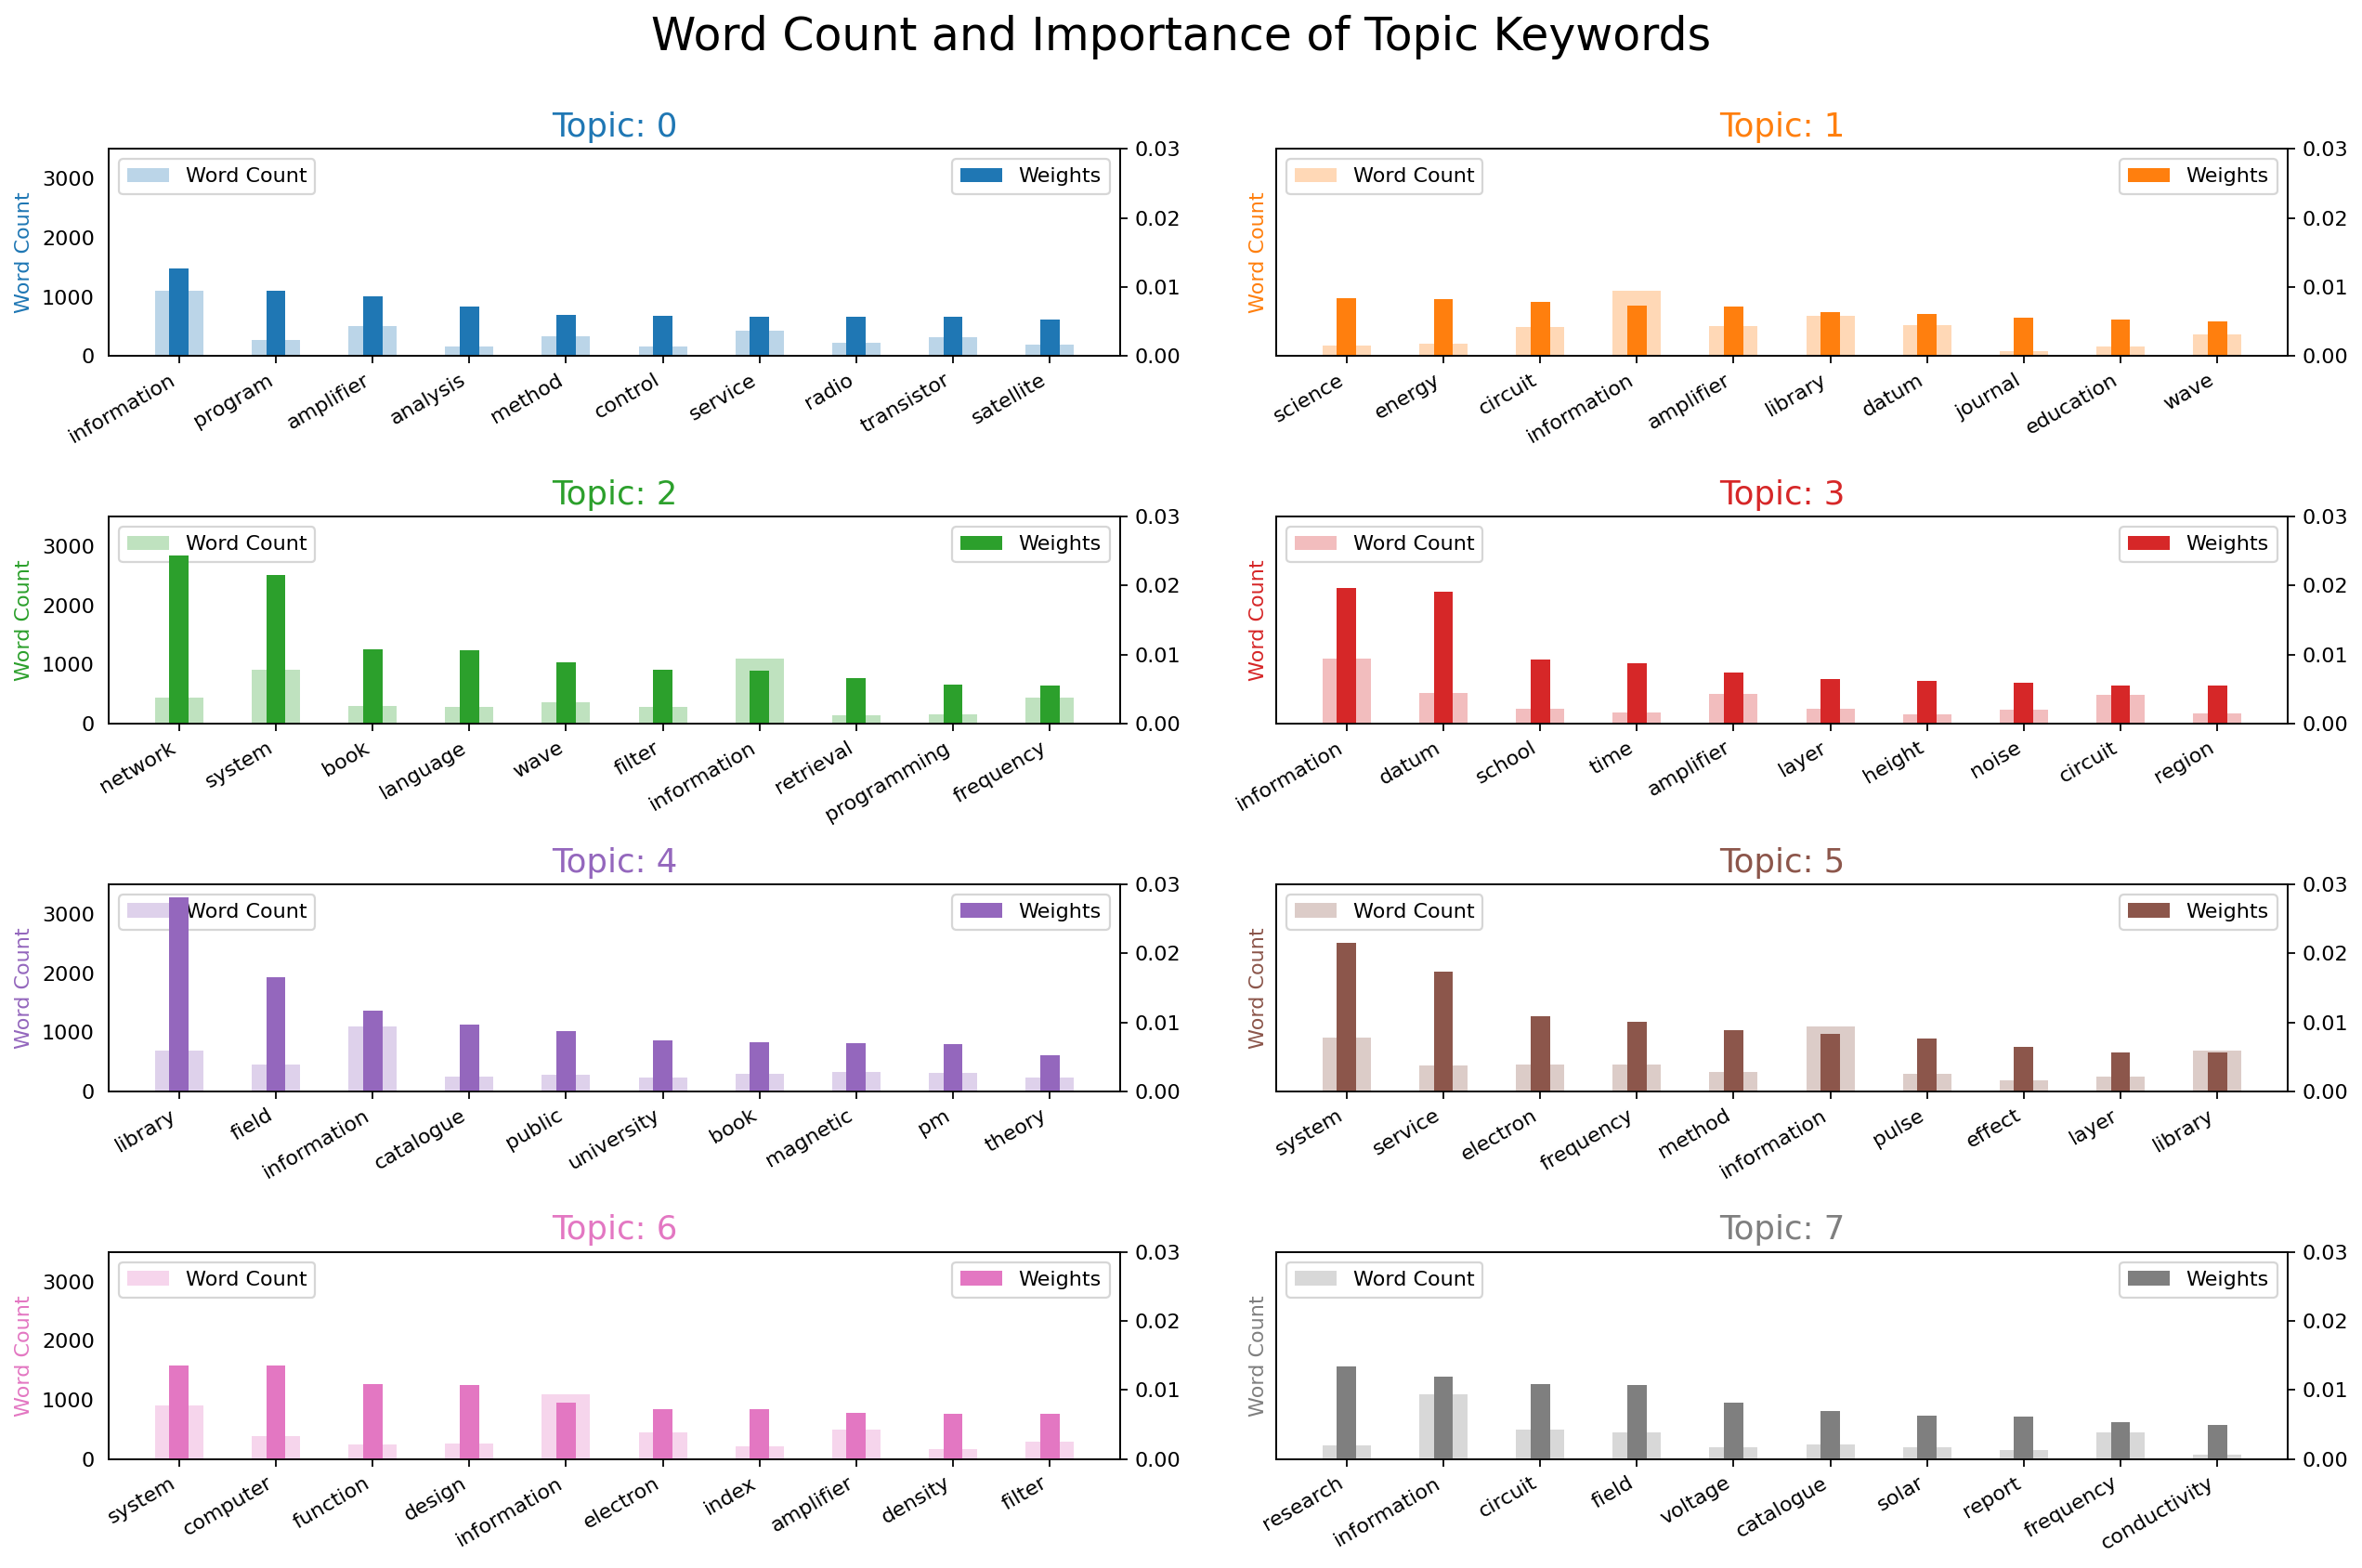

In [15]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_collection for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [16]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
#print(enumerate(lda_model[corpus]))
for i, row_list in enumerate(lda_model[corpus]):
    #print(i, row_list)
    topic_weights.append([w for w in row_list[0]])
#topic_weights = np.array(topic_weights)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print(arr)
# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
#tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[[0.         0.02086616]
 [2.         0.29606259]
 [0.         0.01042342]
 ...
 [0.         0.01043155]
 [0.         0.01044284]
 [5.         0.31937551]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7848 samples in 0.005s...
[t-SNE] Computed neighbors for 7848 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7848


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 2000 / 7848
[t-SNE] Computed conditional probabilities for sample 3000 / 7848
[t-SNE] Computed conditional probabilities for sample 4000 / 7848
[t-SNE] Computed conditional probabilities for sample 5000 / 7848
[t-SNE] Computed conditional probabilities for sample 6000 / 7848
[t-SNE] Computed conditional probabilities for sample 7000 / 7848
[t-SNE] Computed conditional probabilities for sample 7848 / 7848
[t-SNE] Mean sigma: 0.000001


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.571938
[t-SNE] KL divergence after 1000 iterations: 0.342329


Loading BokehJS ...

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

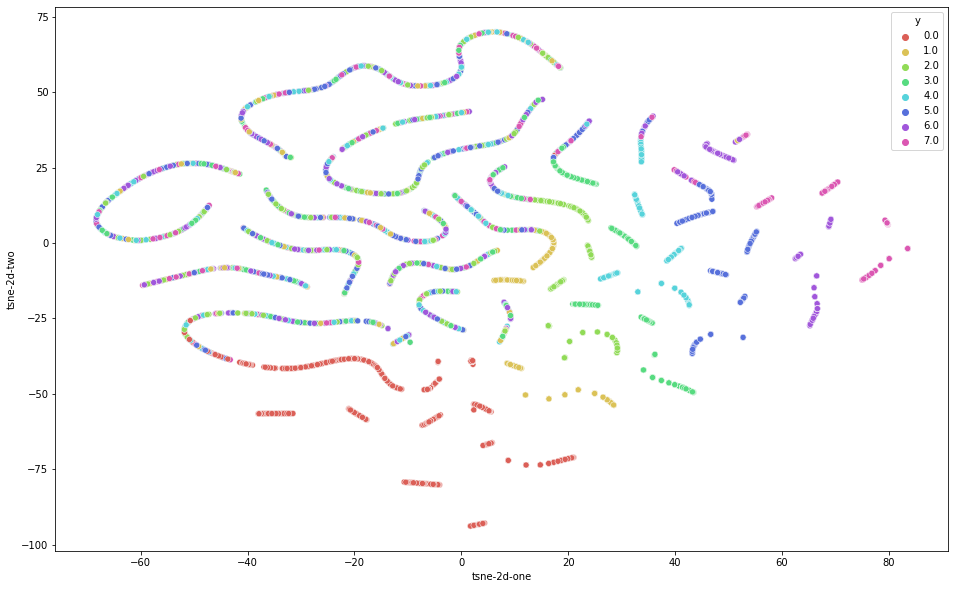

In [17]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_lda[:,0]
df_subset['tsne-2d-two'] = tsne_lda[:,1]
df_subset['y'] = df_dominant_topic['Dominant_Topic']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", num_topics),
    data=df_subset,
    legend="full",
    alpha=0.99
)
